<a href="https://colab.research.google.com/github/Coding-Forest/2021-Mathematics/blob/main/CALC_I_7_Gradients.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CALC I 7 Gradients
References

My Calculus learning notebook following the live lesson series by Dr. Jon Krohn. I adapted some and partially modified or added entirely new code. Notes largely based on and from Jon's notebooks and learning materials. The lesson and original notebook source code at:

- https://learning.oreilly.com/videos/calculus-for-machine/9780137398171/  
- https://github.com/jonkrohn/ML-foundations/blob/master/notebooks/4-calculus-ii.ipynb

## Basic setup

In [1]:
import numpy as np
import torch
import math # for constant pi
import matplotlib.pyplot as plt

import cv2
from google.colab.patches import cv2_imshow
from google.colab import drive
drive.mount('here')

# shows the image immediately. Resize option available
def display_work(path, resize=None):
  img = cv2.imread(path)
  if (resize != None):
    img = cv2.resize(img, dsize=(0,0), fx=resize[0], fy=resize[1])
  cv2_imshow(img)

# turns the path into an image object. Resize option available
def get_img(path, resize=None):
  img = cv2.imread(path)
  if (resize != None):
    img = cv2.resize(img, dsize=(0,0), fx=resize[0], fy=resize[1])
  return img

def cite_source(img, source, org=None, scale=None):
    if (org == None):
        img = cv2.putText(img, source, org=(int(np.ceil(img.shape[1]*0.1)), int(np.ceil(img.shape[0]*0.98))),
                          fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=scale, color=1)
    elif (org != None):
        if (type(org) == tuple):
            img = cv2.putText(img, source, org=org,
                                fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=scale, color=1)
    return img

def take_notes(img, source, org, scale=None):
    if (org == None):
        img = cv2.putText(img, source, org=( int(np.ceil( img.shape[1] * 0.9 )), int(np.ceil( img.shape[0] * 0.1 )) ),
                          fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=scale, color=1)
    elif (org != None):
        img = cv2.putText(img, source, org=( int(np.ceil( img.shape[1] * org[0] )), int(np.ceil( img.shape[0] * org[1] )) ),
                          fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=scale, color=1)
    return img

# Code by Bill Grates on Stackoverflow
# https://stackoverflow.com/users/5629538/bill-grates
# https://stackoverflow.com/questions/32609098/how-to-fast-change-image-brightness-with-python-opencv

def increase_brightness(img, value=30):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) 
    h, s, v = cv2.split(hsv)
    print(v)

    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value
    
    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

Mounted at here


## Study Note tools

### Display image/notes

In [ ]:
# display work
path = ""
img = get_img(path, resize=(0.7,0.7))
img = cite_source(img, "lecture slide from 7.2 Partial Derivatives of Quadratic Cost by dr. Jon Krohn", scale=0.75)
img = take_notes(img, " ", org=(1/5,2/3), scale=0.5)
img = take_notes(img, " .", org=(1/10,5/7), scale=0.5)
#img = increase_brightness(img, value=75)
cv2_imshow(img)

## 7.1 Single-Point Regression

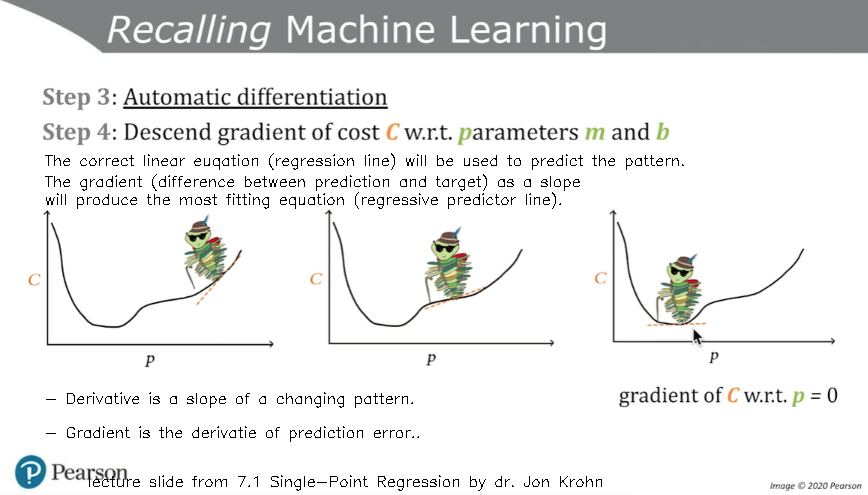

In [ ]:
# display work
path = "/content/here/MyDrive/Math works/cost func.png"
img = get_img(path, resize=(0.75, 0.75))
img = cite_source(img, "lecture slide from 7.1 Single-Point Regression by dr. Jon Krohn", scale=0.5)
img = take_notes(img, "The correct linear euqation (regression line) will be used to predict the pattern.", org=(1/20,5/15), scale=0.5)
img = take_notes(img, "The gradient (difference between prediction and target) as a slope", org=(1/20,6/16), scale=0.5)
img = take_notes(img, "will produce the most fitting equation (regressive predictor line).", org=(1/20,7/17), scale=0.5)
img = take_notes(img, "- Derivative is a slope of a changing pattern.", org=(1/20,13/16), scale=0.5)
img = take_notes(img, "- Gradient is the derivatie of prediction error..", org=(1/20,15/17), scale=0.5)
#img = increase_brightness(img, value=75)
cv2_imshow(img)

So we are looking for a point where the slope becomes flat, because then it will make the whole $Cost$ 0 (cheap cheap!).

In [ ]:
xs = torch.tensor(np.arange(0, 8, 1))
ys = torch.tensor([1.86, 1.31, .62, .33, .09, -.67, -1.23, -1.37])
xs

tensor([0, 1, 2, 3, 4, 5, 6, 7])

In [ ]:
def regression(x, m, b):
    return x * m + b

First, initialize $m$ and $b$ with the same "random" near-zero values.

In [ ]:
m = torch.tensor([0.9]).requires_grad_()
b = torch.tensor([0.1]).requires_grad_()

To keep the partial derivatives as simple as possible, let's move forward with a single instance $i$ from the eight possible data points:

In [ ]:
i = 7
x = xs[i]
y = ys[i]
x, y

(tensor(7), tensor(-1.3700))

### Step 1: Forward pass
We can flow the scalar tensor $x$ through our regression model to produce $\hat{y}$, an estimate of $y$. Prior to any model training, this is an arbitrary estimate:

In [ ]:
y_hat = regression(x, m, b)
y_hat   # the value is so and so (a random 6.4 instead of the correct target -1.37)
        # This is because we gave whatever values to m (0.9) and b (0.1) just to start the regression process.
        # in fact, we have NO IDEA if 0.9 and 0.1 are correct values :P 

tensor([6.4000], grad_fn=<AddBackward0>)

### Step 2: Get difference

Compare $\hat{y}$ with true $y$ to calculate cost $C$

In the Regression in PyTorch notebook, we used mean-squared error, which averages quadratic cost over multiple data points. With a single data point, here we can use quadratic cost alone. It is defined by:
$$ C = (\hat{y} - y)^2 $$

Prior to the model training, however, this $\hat y$ is NOT going to be close to the correct target $y$.

<br/>

Again (recap), why square the difference? 
- The difference remains always $positive$.
- The difference represents an exponentially ($^2$) bigger cost. 
    - The difference looks more striking when squared.

In [ ]:
# Quadratic cost = squared_error
def squared_error(y_hat, y):
    return (y_hat - y)**2

In [ ]:
C = squared_error(y_hat, y)
C

tensor([60.3729], grad_fn=<PowBackward0>)

### Step 3: Automatic differentiation
Calculate Gradient
Use autodiff to calculate gradient of $C$ w.r.t. parameters

In [ ]:
C.backward() # this calculates the gradient of C for paramters. 
             # this class C backwarded by backward(), now has .grad values as its self.variables.

The partial derivative of $C$ with respect to $m$ ($\frac{\partial C}{\partial m}$) is:

In [ ]:
m.grad

tensor([108.7800])

And the partial derivative of $C$ with respect to $b$ ($\frac{\partial C}{\partial b}$) is:

In [ ]:
b.grad

tensor([15.5400])

## 7.2 Partial Derivatives of Quadratic Cost


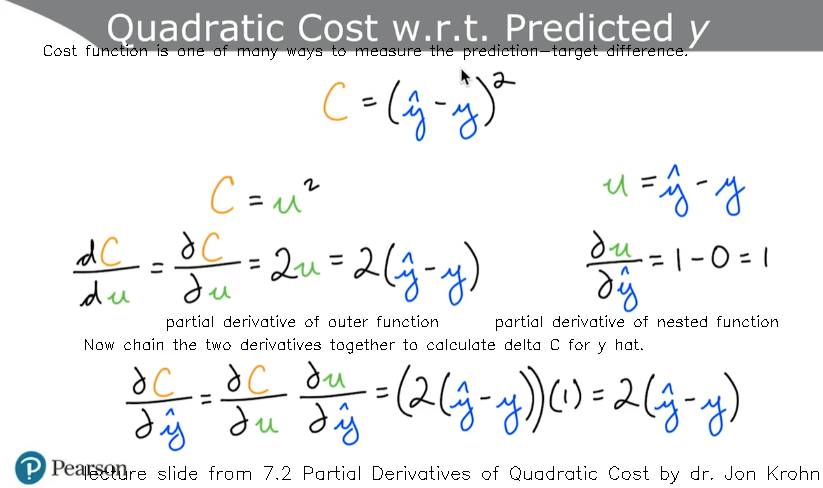

In [ ]:
# display work
path = "/content/here/MyDrive/Math works/quadratic cost for y.png"
img = get_img(path, resize=(0.7,0.7))
img = cite_source(img, "lecture slide from 7.2 Partial Derivatives of Quadratic Cost by dr. Jon Krohn", scale=0.6)
img = take_notes(img, "Cost function is one of many ways to measure the prediction-target difference.", org=(1/20,1/9 ), scale=0.5)
img = take_notes(img, "partial derivative of nested function", org=(6/10,2/3), scale=0.5)
img = take_notes(img, "partial derivative of outer function", org=(1/5,2/3), scale=0.5)
img = take_notes(img, "Now chain the two derivatives together to calculate delta C for y hat.", org=(1/10,5/7), scale=0.5)
#img = increase_brightness(img, value=75)
cv2_imshow(img)

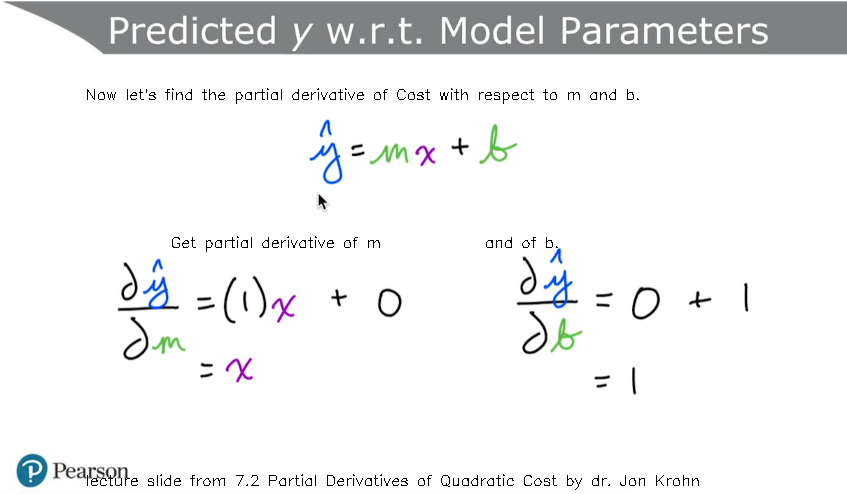

In [ ]:
# display work
path = "/content/here/MyDrive/Math works/slope to chain.png"
img = get_img(path, resize=(0.7,0.7))
img = cite_source(img, "lecture slide from 7.2 Partial Derivatives of Quadratic Cost by dr. Jon Krohn", scale=0.5)
img = take_notes(img, "Now let's find the partial derivative of Cost with respect to m and b.", org=(1/10,1/5), scale=0.5)
img = take_notes(img, "Get partial derivative of m", org=(1/5,1/2), scale=0.5)
img = take_notes(img, "and of b.", org=(4/7, 1/2), scale=0.5) 
#img = increase_brightness(img, value=75)
cv2_imshow(img)

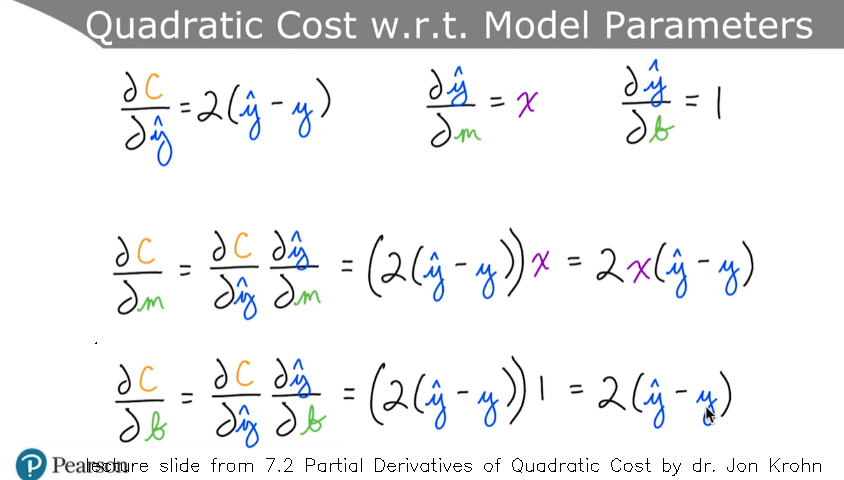

In [ ]:
# display work
path = "/content/here/MyDrive/Math works/quadratic cost.png"
img = get_img(path, resize=(0.7,0.7))
img = cite_source(img, "lecture slide from 7.2 Partial Derivatives of Quadratic Cost by dr. Jon Krohn", scale=0.6)
img = take_notes(img, " ", org=(1/5,2/3), scale=0.5)
img = take_notes(img, " .", org=(1/10,5/7), scale=0.5)
#img = increase_brightness(img, value=75)
cv2_imshow(img)

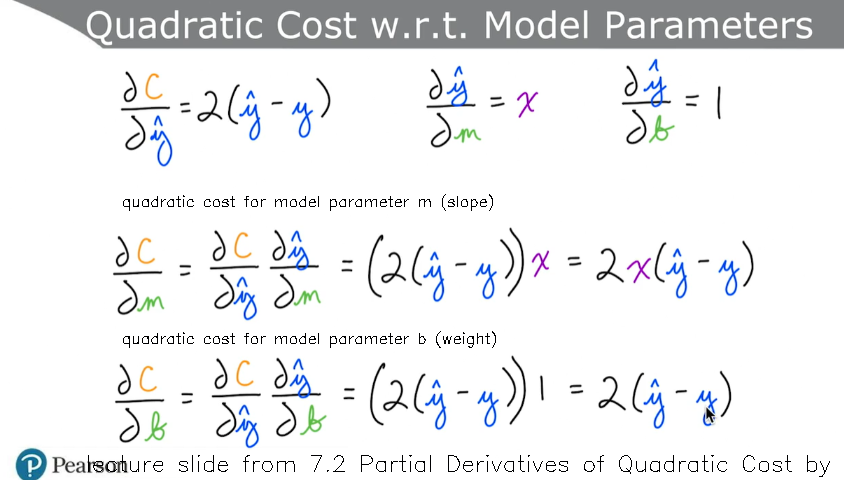

In [ ]:
# display work
path = "/content/here/MyDrive/Math works/quadratic cost.png"
img = get_img(path, resize=(0.7,0.7))
img = cite_source(img, "lecture slide from 7.2 Partial Derivatives of Quadratic Cost by dr. Jon Krohn", scale=0.75)
img = take_notes(img, "quadratic cost for model parameter m (slope)", org=(1/7,3/7), scale=0.5)
img = take_notes(img, "quadratic cost for model parameter b (weight)", org=(1/7,5/7), scale=0.5)
#img = increase_brightness(img, value=75)
cv2_imshow(img)

### Hands-on code demo

Return to Calculus II slides here to derive $\frac{\partial C}{\partial m}$ and $\frac{\partial C}{\partial b}$.

$$ \frac{\partial C}{\partial m} = 2x(\hat{y} - y) $$

In [ ]:
# partial derivative of prediction-target difference (which is essential the slope)
2 * x * (y_hat.item() - y)

tensor(108.7800)


$$ \frac{\partial C}{\partial b} = 2(\hat{y}-y) $$

In [ ]:
# partial derivative of bias (y-intercept in a linear equation)
2 * (y_hat.item() - y)

tensor(15.5400)

## 7.3 Descending the Gradient of Cost

The Gradient of Cost, $\nabla C$
The gradient of cost, which is symbolized $\nabla C$ (pronounced "nabla C"), is a vector of all the partial derivatives of $C$ with respect to each of the individual model parameters:


## 7.4 Gradient of Mean Squared Error


In [ ]:
# display work
path = ""
img = get_img(path, resize=(0.7,0.7))
img = cite_source(img, "lecture slide from 7.2 Partial Derivatives of Quadratic Cost by dr. Jon Krohn", scale=0.75)
img = take_notes(img, " ", org=(1/5,2/3), scale=0.5)
img = take_notes(img, " .", org=(1/10,5/7), scale=0.5)
#img = increase_brightness(img, value=75)
cv2_imshow(img)


$\nabla C = \nabla_p C = \left[ \frac{\partial{C}}{\partial{p_1}}, \frac{\partial{C}}{\partial{p_2}}, \cdots, \frac{\partial{C}}{\partial{p_n}} \right]^T $


In this case, there are only two parameters, $b$ and $m$:

$\nabla C = \left[ \frac{\partial{C}}{\partial{b}}, \frac{\partial{C}}{\partial{m}} \right]^T $

In [ ]:
gradient = torch.tensor([[b.grad.item(), m.grad.item()]]).T
gradient

tensor([[ 15.5400],
        [108.7800]])

### Problem 1.


Answer: 

## 7.5 Backpropagation



## 7.6 Higher-Order Partial Derivatives


## 7.7 Exercise

# Frequent Functions
- ```func```  
    - source

- ```func```  
    - source

- ```func```  
    - source

- ```func```  
    - source


# Error Notes
- ```error```  
    - source

- ```error```  
    - source

- ```error```  
    - source

- ```error```  
    - source

